# Captum + Quantus + FusionGrad


Install all required libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
    !pip install torch torchvision captum quantus lovely_tensors
    !pip install "matplotlib<3.7"
    !wget -P ./xai_assets https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
    !wget -P ./xai_assets https://modernfarmer.com/wp-content/uploads/2021/05/shutterstock_339099548.jpg
    !wget -P ./xai_assets https://cdn.pixabay.com/photo/2018/04/07/20/32/swan-3299528_1280.jpg
    !pip install quantus --no-dependencies

    !pip install git+https://github.com/OscarPellicer/txyvis.git
    !pip install git+https://github.com/OscarPellicer/tiled_occlusion.git

--2024-12-03 19:11:38--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.67.168, 16.182.68.104, 54.231.197.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.67.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘./xai_assets/imagenet_class_index.json.3’

imagenet_class_inde 100%[===================>]  34.53K   184KB/s    in 0.2s    

2024-12-03 19:11:39 (184 KB/s) - ‘./xai_assets/imagenet_class_index.json.3’ saved [35363/35363]

--2024-12-03 19:11:39--  https://modernfarmer.com/wp-content/uploads/2021/05/shutterstock_339099548.jpg
Resolving modernfarmer.com (modernfarmer.com)... 104.21.47.193, 172.67.172.36, 2606:4700:3031::ac43:ac24, ...
Connecting to modernfarmer.com (modernfarmer.com)|104.21.47.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66792 (65K) [image/jpeg]
Saving

Load libraries

In [3]:
import torch
import torch.nn.functional as F

from PIL import Image
from pathlib import Path
import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models, transforms

from captum.attr import IntegratedGradients, GradientShap, Occlusion, NoiseTunnel, visualization as viz

import lovely_tensors as lt
lt.monkey_patch()

Create a function for visualization of images along attributions using my custom library `txyvis`

In [4]:
# Visualize attributions using my custom visualization library
from txyvis import plot_maps

#Create colormap for attribution plotting and register it
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
    v = np.array([0,.15,.4,.5,0.6,.9,1.])
    cmap= mpl.colors.LinearSegmentedColormap.from_list('RdGn', list(zip(v,c)), N=256)
    plt.register_cmap('RdGn', cmap)
except Exception as e:
    print(e)

# We create a function for convenience
def plot_attributions(image, attributions=[], attribution_names=[], limits=None, title=None, figsize=4):
  return plot_maps(
      images=[image[None].flip(dims=[-1,-2]).transpose(-1,-2)] +\
             [attr.mean(axis=1, keepdim=True).flip(dims=[-1,-2]).transpose(-1,-2)
              for attr in attributions],
      cmaps=[None] + ['RdGn']*len(attribution_names),
      centers= [False] + [True]*len(attribution_names),
      ylabels=['Input'] + attribution_names,
      limits= [None] + [limits]*len(attribution_names),
      transpose=True, figsize=figsize, title=title)

Open ImageNet labels, load model, move to GPU

In [5]:
labels_path = './xai_assets/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [6]:
# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device=}')

#See full model list @ https://pytorch.org/vision/stable/models.html
def getCNN():
    #Get pretrained ImageNet CNN
    #model = models.resnet18(pretrained=True) #acc@1 69.758 | acc@5 89.078 | params 11.7M | GFLOPS 1.81
    model = models.efficientnet_b3(pretrained=True) #82.008 | 96.054 | 12.2M | 1.83
    model = model.eval().to(device)
    print(f'Using: {model.__class__}')
    return model

model= getCNN()

Using device=device(type='cuda', index=0)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: <class 'torchvision.models.efficientnet.EfficientNet'>


## Get sample image & predict class with ResNet18

tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-2.118, 2.553] μ=-0.201 σ=1.677 cuda:0


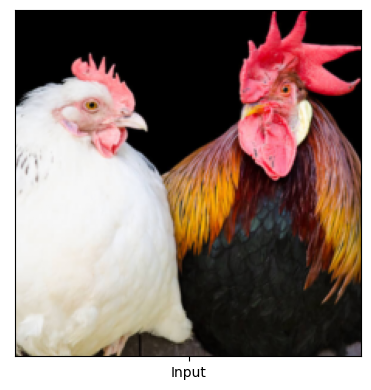

(<Figure size 400x400 with 1 Axes>, <AxesSubplot: >)

In [7]:
#Get sample image
#img = Image.open('./xai_assets/swan-3299528_1280.jpg')
img = Image.open('./xai_assets/shutterstock_339099548.jpg')

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

imagenet_mean, imagenet_std= [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_normalize = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)

transformed_img = transform(img).to(device)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

#Plot image
print(input) #Nice representation thanks to lovely_tensors
plot_attributions(transformed_img) #Using my custom function

In [8]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_scores, pred_label_idxs = torch.topk(output, 5)

for k, (prediction_score, pred_label_idx) in list(enumerate(zip(prediction_scores.squeeze_(),
                                                                pred_label_idxs.squeeze_()))):
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print(f' - {k+1}: {prediction_score.squeeze().item()*100 : 2.2f}%: {predicted_label}')

 - 1:  55.81%: cock
 - 2:  29.81%: hen
 - 3:  0.73%: partridge
 - 4:  0.06%: quail
 - 5:  0.05%: ostrich


## Compute IntGrad attribution

tensor i64 cuda:0 8 hen


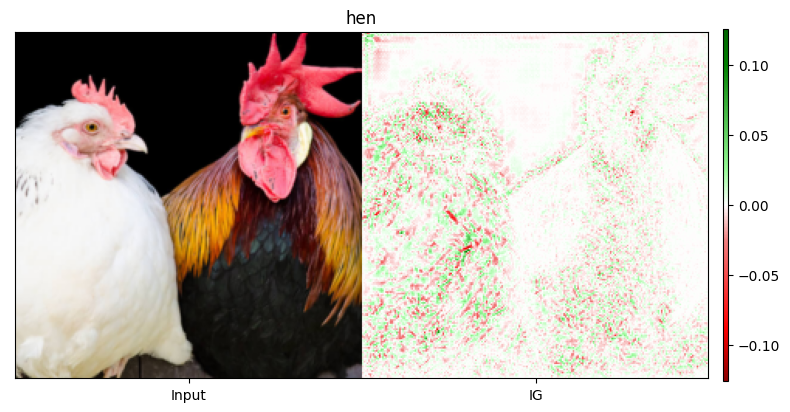

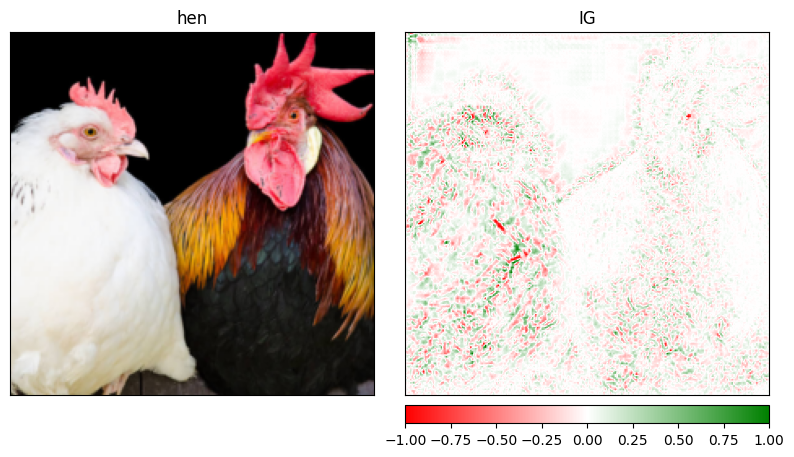

In [9]:
#Predict
idx= 1 #Target prediction class
pred_label_idx= pred_label_idxs.squeeze_()[idx]
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print(pred_label_idx, predicted_label)

#Attribute
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=20)

#Plot
plot_attributions(transformed_img, [attributions_ig], ['IG'], title=predicted_label);

#For reference, this is the captum way of plotting attributions
#But we will be using my function, which allows for comparison of different methods
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              methods= ["original_image", "heat_map"],
#                              signs=  ["all", "all"], titles=[f'{predicted_label}', f'IG'],
#                              show_colorbar=True, outlier_perc=1)

## Saliency (aka Gradient), InputXGradient, GradientSHAP

Using: <class 'torchvision.models.efficientnet.EfficientNet'>


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


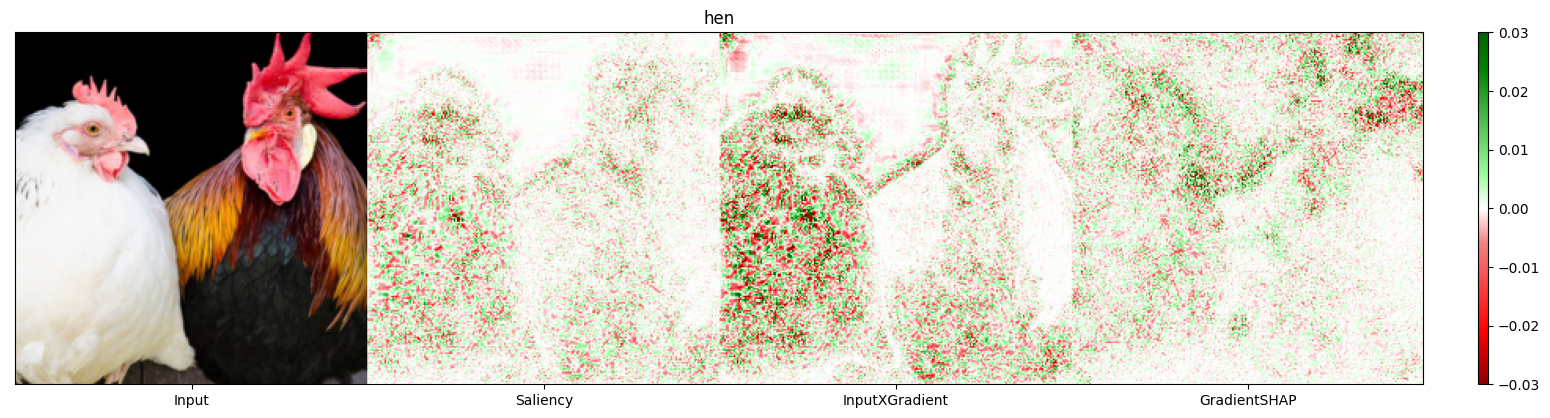

In [10]:
from captum.attr import Saliency, InputXGradient, GradientShap
model= getCNN() #Reset CNN just in case

#Saliency
saliency= Saliency(model)
attributions_sal= saliency.attribute(input, target=pred_label_idx, abs=False)

#InputxGradient
inputxgrad= InputXGradient(model)
attributions_ixg= inputxgrad.attribute(input, target=pred_label_idx)

#GradientSHAP
gradient_shap= GradientShap(model)
baselines= torch.randn(50, *transformed_img.shape).to(device)
attributions_gradshap= gradient_shap.attribute(input, baselines, target=pred_label_idx)

#Plot
attrs_to_plot = [attributions_sal, attributions_ixg, attributions_gradshap]
attrs_name = ['Saliency', 'InputXGradient', 'GradientSHAP']
plot_attributions(transformed_img, attrs_to_plot, attrs_name,
                  limits=(-0.05,0.05), title=predicted_label);

## IntGrad / NoiseGrad / FusionGrad

Using: <class 'torchvision.models.efficientnet.EfficientNet'>


FusionGrad:   0%|          | 0/25 [00:00<?, ?it/s]

FusionGrad:   0%|          | 0/25 [00:00<?, ?it/s]

FusionGrad:   0%|          | 0/25 [00:00<?, ?it/s]

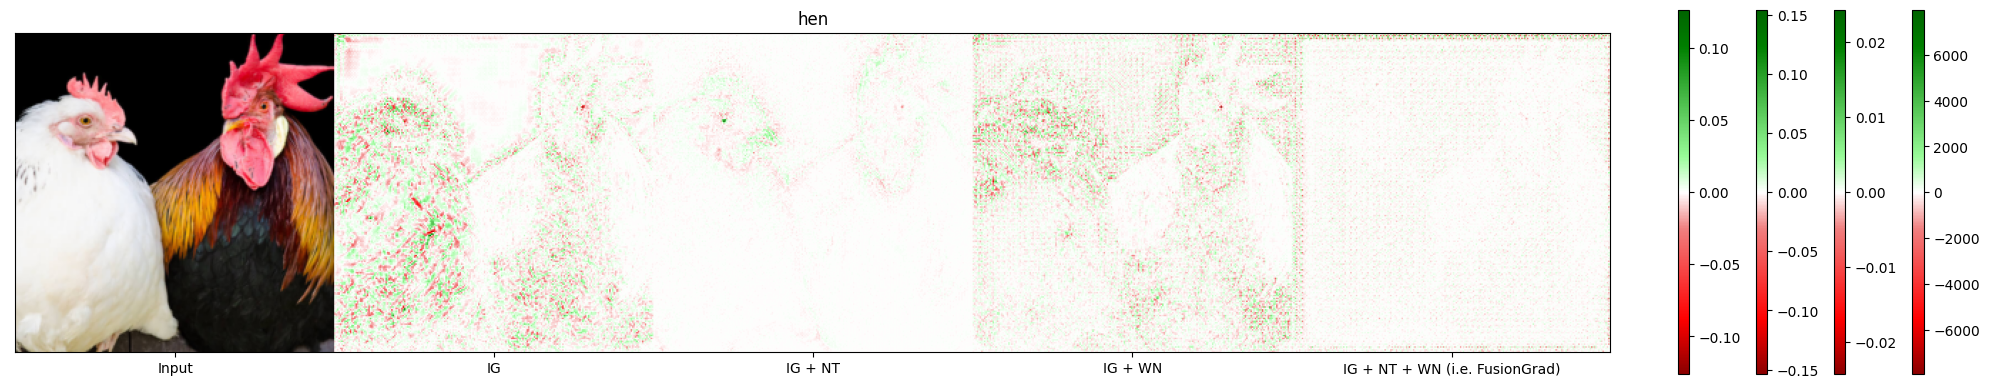

In [112]:
#from tiled_occlusion import TiledOcclusion, FusionGrad

#Equivalent code using official repo for NoiseTunnel
#We will use my code, which adheres to the Captum API
# noise_tunnel = NoiseTunnel(integrated_gradients)
# attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad',
#                                   target=pred_label_idx, stdevs=1.5, internal_batch_size=5)

#Get the explainer
model= getCNN() #Reset CNN just in case
integrated_gradients = IntegratedGradients(model)
fusiongrad= FusionGrad(integrated_gradients, model=model)

#IG + NT: Let's just use NoiseTunnel (aka NoiseGrad): Add noise to the inputs
#We must set std=0 and n=1 to disable FusionGrad, and use NoiseTunnel only
attributions_ig_nt= fusiongrad.attribute(input, target=pred_label_idx,
                            std=0., mean=1., n=1, additive_noise=True, #Weight noise
                            sg_std=1.5, m=25, sg_additive_noise=True, #Input noise
                                         )

#IG + WN: Let's try Weight Noise: Add noise to the weights
attributions_ig_wn= fusiongrad.attribute(input, target=pred_label_idx,
                            std=0.05, mean=1., n=25, additive_noise=False, #Weight noise (mult)
                            # std=0.01, mean=0., n=25, additive_noise=True, #Weight noise (add)
                            sg_std=0., m=1, sg_additive_noise=True, #Input noise
                                         )

# #IG + NT + WN: Let's try with FusionGrad: Add noise to inputs AND weights
attributions_ig_fg= fusiongrad.attribute(input, target=pred_label_idx,
                            std=0.05, mean=1., n=5, additive_noise=False, #Weight noise (mult)
                            sg_std=1.5, m=5, sg_additive_noise=True, #Input noise
                                         )

#Plot
plot_attributions(transformed_img,
  [attributions_ig, attributions_ig_nt, attributions_ig_wn, attributions_ig_fg],
  ['IG', 'IG + NT', 'IG + WN', 'IG + NT + WN (i.e. FusionGrad)'],
  title=predicted_label);

## Occlusion-based attribution

In [12]:
#Attribute
model= getCNN()
occlusion= Occlusion(model)
attributions_occ= occlusion.attribute(input, strides=(3,6,6), target=pred_label_idx,
                    sliding_window_shapes=(3,6,6), baselines=0, show_progress=True)

#Plot
plot_attributions(transformed_img, [attributions_occ], ['Occlusion'], title=predicted_label);

Using: <class 'torchvision.models.efficientnet.EfficientNet'>


Occlusion attribution:   0%|          | 0/1445 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Tiled occlusion-based attribution

In [ ]:
#Attribute and plot
tiled_occlusion= TiledOcclusion(model)
attributions_tocc= tiled_occlusion.attribute(input, target=pred_label_idx,
                                             k=[1,2,2], window= [3,12,12])
plot_attributions(transformed_img, [attributions_occ], ['Occlusion'], title=predicted_label);

## Occlusion + NoiseTunnel

In [ ]:
#Attribute and plot
noise_tunnel_occ = NoiseTunnel(occlusion)
attributions_occ_nt = noise_tunnel_occ.attribute(input, nt_samples=6, nt_type='smoothgrad',
                        target=pred_label_idx, stdevs=.5,
                        strides=(3,8,8), sliding_window_shapes=(3,8,8), baselines=0)
plot_attributions(transformed_img, [attributions_occ], ['Occlusion'], title=predicted_label);

## Evaluate the explainations using Quantus

In [ ]:
import quantus

#Required by GradientShap
baselines= torch.randn(50, *transformed_img.shape).to(device)

#Attribution methods
attrib_fns= {
     'IG': lambda inputs, targets, model, device, **kwargs:
        IntegratedGradients(model).attribute(torch.tensor(inputs).to(device),
                target=torch.tensor(targets).to(device), n_steps=20).cpu().detach().numpy(),
     'Saliency': lambda inputs, targets, model, device, **kwargs:
        Saliency(model).attribute(torch.tensor(inputs).to(device),
                target=torch.tensor(targets).to(device), abs=False).cpu().detach().numpy(),
     'InputXGrad': lambda inputs, targets, model, device, **kwargs:
        InputXGradient(model).attribute(torch.tensor(inputs).to(device),
                target=torch.tensor(targets).to(device)).cpu().detach().numpy(),
     'GradShap': lambda inputs, targets, model, device, **kwargs:
        GradientShap(model).attribute(torch.tensor(inputs).to(device), baselines,
                target=torch.tensor(targets).to(device)).cpu().detach().numpy(),
     'IG + NT': lambda inputs, targets, model, device, **kwargs:
        NoiseTunnel(IntegratedGradients(model)).attribute(torch.tensor(inputs).to(device),
                nt_samples=10, nt_type='smoothgrad',
                target=torch.tensor(targets).to(device), stdevs=1.5,
                internal_batch_size=5).cpu().detach().numpy(),
     'OCC': lambda inputs, targets, model, device, **kwargs:
        Occlusion(model).attribute(torch.tensor(inputs).to(device), strides=(3,12,12),
                target=torch.tensor(targets).to(device),
                sliding_window_shapes=(3,12,12), baselines=0, show_progress=True).cpu().detach().numpy(),
     'TOCC': lambda inputs, targets, model, device, **kwargs:
        tiled_occlusion(Occlusion(model), torch.tensor(inputs).to(device),
                torch.tensor(targets).to(device),
                k=2, window= tuple([3] + [24]*2), show_progress=True).cpu().detach().numpy(),
     'OCC + NT': lambda inputs, targets, model, device, **kwargs:
        NoiseTunnel(Occlusion(model)).attribute(torch.tensor(inputs).to(device),
                nt_samples=6, nt_type='smoothgrad', baselines=0,
                target=torch.tensor(targets).to(device),
                stdevs=.5, strides=(3,12,12), sliding_window_shapes=(3,12,12)).cpu().detach().numpy()
        }

a_batch= torch.cat([attributions_ig, attributions_sal.detach(), attributions_ixg.detach(),
                    attributions_gradshap.detach(), attributions_ig_nt,
                    #expl_ng.repeat(3,1,1)[None].to(device), expl_ngp.repeat(3,1,1)[None].to(device),
                    attributions_occ, attributions_tocc, attributions_occ_nt], axis=0).cpu().numpy()
# x_batch= input.repeat(len(a_batch), 1,1,1).cpu().numpy()
# y_batch= pred_label_idx[None].repeat(len(a_batch),1,1,1).cpu().numpy()

#Attribution metrics
metrics = {
    "AvgSensitivity": quantus.AvgSensitivity(
        nr_samples=10,
        lower_bound=0.2,
        norm_numerator=quantus.norm_func.fro_norm,
        norm_denominator=quantus.norm_func.fro_norm,
        perturb_func=quantus.perturb_func.uniform_noise,
        similarity_func=quantus.similarity_func.difference,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "FaithfulnessCorrelation": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="black",
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=False,
        disable_warnings=True,
    ),
    # "Complexity": quantus.Sparseness(
    #     abs=True,
    #     normalise=False,
    #     aggregate_func=np.mean,
    #     return_aggregate=True,
    #     disable_warnings=True,
    # ),
    "RandomLogit": quantus.RandomLogit(
        num_classes=1000,
        similarity_func=quantus.similarity_func.ssim,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

#Iterate over both and compute results
from collections import defaultdict
results= defaultdict(dict)
x= input.cpu().numpy()
y= pred_label_idx.cpu().numpy()
for a, (attribs_name, attribs_fn) in zip(a_batch, attrib_fns.items()):
    for metric_name, metric in metrics.items():
        res= metric(x_batch=x, y_batch=y[None],
                    a_batch=a[None],
                    model=model, device=device, explain_func=attribs_fn)
        print(f' - {attribs_name} - {metric_name}: {res[0]:.4f}')
        results[metric_name][attribs_name]= res[0]

In [ ]:
# results= {'Robustness': {'IG': 0.027719198891947454,
#     'Saliency': 0.016748874774805845,
#     'InputXGrad': 0.030524090263258263,
#     'GradShap': 0.01056196189065808,
#     'IG + NT': 0.005122031178488744,
#     'OCC': 0.3067441295731826,
#     'TOCC': 1.8388330512101632,
#     'OCC + NT': 0.18974229843760507},
#     'Faithfulness': {'IG': 0.2200333147487273,
#     'Saliency': -0.7103643643103636,
#     'InputXGrad': -0.4374974628686659,
#     'GradShap': 0.08300295300738836,
#     'IG + NT': -0.47446075619169004,
#     'OCC': 0.0036152492227930766,
#     'TOCC': -0.04538545459960114,
#     'OCC + NT': -0.005516642113466974},
#     'Randomisation': {'IG': 0.7977087220523448,
#     'Saliency': 0.8517238701354092,
#     'InputXGrad': 0.7729956824206197,
#     'GradShap': 0.9097353614945933,
#     'IG + NT': 0.9792968845751187,
#     'OCC': 0.30916985528508795,
#     'TOCC': 0.18262851584164522,
#     'OCC + NT': 0.41540062632506464}}
results

In [ ]:
#Note:
# - Robustness (AvgSensitivity) (LOWER is better)
        # The Avereage-Sensitivity (Yeh et al., 2019) metric measures the reliability in terms of the average change in
        # an explanation with small input perturbations and it is estimated using Monte Carlo sampling.
        # Naturally, we would not prefer an explanation to have high Max-Sensitivity, since that would entail differing
        # explanations with minor variations in the input. This fact might lead us to distrust the explanations
# - Faithfulness (FaithfulnessCorrelation) (HIGHER is better)
        # Faithfulness correlation by Bhatt et al., 2020.
        # The Faithfulness Correlation metric intend to capture an explanation's relative faithfulness
        # (or 'fidelity') with respect to the model behaviour.
        # Faithfulness correlation scores shows to what extent the predicted logits of each modified test point and
        # the average explanation attribution for only the subset of features are (linearly) correlated, taking the
        # average over multiple runs and test samples. The metric returns one float per input-attribution pair that
        # ranges between -1 and 1, where higher scores are better.
        # For each test sample, |S| features are randomly selected and replace them with baseline values (zero baseline
        # or average of set). Thereafter, Pearson’s correlation coefficient between the predicted logits of each modified
        # test point and the average explanation attribution for only the subset of features is calculated. Results is
        # average over multiple runs and several test samples.
# - Randomisation (RandomLogit) (HIGHER is better)
        # Implementation of the Random Logit Metric by Sixt et al., 2020.
        # The Random Logit Metric computes the distance between the original explanation and a reference explanation of
        # a randomly chosen non-target class.

import pandas as pd
df= pd.DataFrame(results)
df

In [ ]:
# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
# Take inverse ranking for Robustness, since lower is better
normalize= lambda x: (x - x.min()) / (x.max() - x.min())
df_normalised = df.loc[:, df.columns != 'AvgSensitivity'].apply(normalize)
df_normalised["AvgSensitivity"]= normalize(-df["AvgSensitivity"])
df_normalised_plot= df_normalised #df_normalised.rank()

#Plotting configs
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.8)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True
include_titles = True
include_legend = True
sns.set()

#Make spyder graph!
data = [df_normalised_plot.columns.values, (df_normalised_plot.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], attrib_fns.keys())):
    line = ax.plot(theta, d, label=method, linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

ax.set_varlabels(labels=list(metrics.keys()))
ax.set_rgrids(np.arange(0, df_normalised_plot.values.max() + 0.5), labels=[])
ax.set_title("Summary of several XAI methods and metrics", position=(0.5, 1.1), ha='center', fontsize=15)
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()